# Машинное обучение и майнинг данных

## 16/02/2017 Линейные модели, практика

# Логистическая регрессия

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

Рассмотрим данные по кредитованию.

Столбец с классом называется `y`.<br/> Значение $1$ соответствует классу клиентов банка, которым выдали кредит и они его успешно вернули.<br/> Значение $-1$ соответствует клиентам, невыполнившим свои кредитные обязанности. 

В банке хотят уметь определять по признакам `a1-a15`, сможет ли новый клиент вернуть кредит или нет? То есть нам надо обучить классификатор! *Обычно, в банках используют скор-карты, но процесс их построения тесно связан с логистической регрессией*

Загрузите данные и преобразуйте признаки `a1`, `a9`, `a10` и `a12` из строковых в числовые. В них только 2 возможных значения. Для этого можно использовать функцию DataFrame.replace() в `pandas` или самое обычное присваивание на соответствующих строках.

In [26]:
import pandas as pd

In [27]:
df = pd.read_csv('crx.data')

df.head()

,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,y
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


### Предобработка данных

#### Заполнение пропусков

Заполните пропуски в данных

In [28]:
df.a1 = df.a1.fillna(value=df.a1.mode().values[0])
df.a2 = df.a2.fillna(value=df.a2.median())

df.a4 = df.a4.fillna(value=df.a4.mode().values[0])
df.a5 = df.a5.fillna(value=df.a5.mode().values[0])
df.a6 = df.a6.fillna(value=df.a6.mode().values[0])
df.a7 = df.a7.fillna(value=df.a7.mode().values[0])

df.a14 = df.a14.fillna(value=df.a14.median())

#### Преобразование признаков

В признаках `a6`, `a7` присутствуют "редкие" значение. Найдите их с помощью фунцкии `.value_counts()`  и объедините, присвоив им одно и то же значение, например `'Other'`.

In [29]:
# Your code here
df.a7.replace({'z': 'Other', 'j': 'Other', 'dd': 'Other',
               'n': 'Other', 'o': 'Other'}, inplace=True)

df.a6.replace({'j': 'Other', 'r': 'Other'}, inplace=True)

# df.a6 = af.a6.replace({'j': 'Other', 'r': 'Other'}, inplace=True)

Влияние категориальной (да и в общем-то любой) переменной на целевую переменную можно с помощью разных метрик.

Для категорий есть мера [Normalized Mutual Information](https://en.wikipedia.org/wiki/Mutual_information)

Выделите бинарные признаки `a1`, `a9`, `a10` и `a12` в матрицу `X_binary`

In [30]:
# Your code here
df.a1.replace({'a': 1, 'b': 0}, inplace=True)
df.a9.replace({'t': 1, 'f': 0}, inplace=True)
df.a10.replace({'t': 1, 'f': 0}, inplace=True)
df.a12.replace({'t': 1, 'f': 0}, inplace=True)

X_binary= df.loc[:, ['a1', 'a9', 'a10','a12']].values

На занятиях мы изучатли преобразование категориальных признаков с помощью комбинации `LabelEncoder` и `OneHotEncoder` или метода `pd.get_dummies`. <br\>

Есть еще один способ из библиотеки sklearn - `DictVectorizer`. Если хотите - можете разобраться, что делает код ниже, изучая промежуточные результаты каждой из команд.

In [31]:
from sklearn.feature_extraction import DictVectorizer

In [32]:
dv = DictVectorizer(sparse=False)
dv.fit(df[['a5', 'a6', 'a7', 'a13']].T.to_dict().values())

X_cat = dv.transform(df[['a5', 'a6', 'a7', 'a13']].T.to_dict().values())

In [33]:
X_cat.shape

(690, 24)

`X_cat` - эквивалентна последовательному применению `LabelEncoder` к каждому признаку `a5`, `a6`, `a7`, `a13` и использованию `OneHotEncoder`. Чтобы узнать, чему соответствует каждый столбец матрицы `X_cat` используйте команду `dv.feature_names_`

In [34]:
dv.feature_names_

['a13=g',
 'a13=p',
 'a13=s',
 'a5=g',
 'a5=gg',
 'a5=p',
 'a6=Other',
 'a6=aa',
 'a6=c',
 'a6=cc',
 'a6=d',
 'a6=e',
 'a6=ff',
 'a6=i',
 'a6=k',
 'a6=m',
 'a6=q',
 'a6=w',
 'a6=x',
 'a7=Other',
 'a7=bb',
 'a7=ff',
 'a7=h',
 'a7=v']

Вы долнжы увидеть список с элементами вида <Признак>=<Значение>. Если в каком-то из случаев это не так, то
* Либо `DictVectorizer` посчитал, что признак - некатегориальный
* Либо в признаке есть пропуски

С помощью метода  df[..].corr() убедитесь, что признаки `a2`, `a3`, `a8`, `a11`, `a14` и `a15` довольно слабо коррелируют друг с другом.

In [35]:
df.loc[:, ['a2', 'a3', 'a8', 'a11', 'a14', 'a15']].corr()

,a2,a3,a8,a11,a14,a15
a2,1.000000,0.202177,0.391464,0.187327,-0.079844,0.018719
a3,0.202177,1.000000,0.298902,0.271207,-0.222026,0.123121
a8,0.391464,0.298902,1.000000,0.322330,-0.075703,0.051345
a11,0.187327,0.271207,0.322330,1.000000,-0.119029,0.063692
a14,-0.079844,-0.222026,-0.075703,-0.119029,1.000000,0.064847
a15,0.018719,0.123121,0.051345,0.063692,0.064847,1.000000


In [36]:
from sklearn.preprocessing import StandardScaler

Нормализуйте количественные признаки `a2`, `a3`, `a8`, `a11`, `a14` и `a15` с помощью `StandartScaler` или вручную. Вы должны получить матрицу `X_real`.

**МЕТОДОЛОГИЧЕСКИЙ КОСЯК:** нужно сначала разбить на трейн и тест, а потом использовать всякое шкалирование и кодирование. Но для целей этого задания - это не так вредно.

In [37]:
scaler = StandardScaler()
X_real = scaler.fit_transform(df[['a2', 'a3', 'a8', 'a11', 'a14', 'a15']].values)

Используйте функцию `np.concatinate(..)` или `np.c[..]` чтобы сцепить матрицы `X_binary`, `X_cat` и `X_real`

В результате вы должны получить матрицу с преобразованными призанками `X` и вектор ответов `y`

In [39]:
X = np.c_[X_binary, X_cat, X_real]
y = df.loc[:, 'y'].values

In [40]:
X.shape

(690, 34)

### Регуляризация

Помимо мультиколлинеарности логистическая регрессия так же может быть подвержена переобучению. Как правило, на деле это выражается в 
* Очень больших весах $|w_i|$ при признаках
* Неустойчивости решения (особенно в случае мультиколлинеарности, когда возникает линейная зависимость признаков и получается целое семейство равнозначных моделей)
* Большая разница в качестве на обучении и валидации

Регуляризация - это техника понижения "сложности" модели с минимальными последствиями для её качества.

В случае с логистичесткой регресии, сложность модели выражается в значениях весов $w_j$ при признаках. Больший вес означает большее влияние признака на результат. В таком случае, давайте добавил штрафное слагаемое в функцию оптимизации для логистической регресии. Самый распространенные из них это:

* Ridge regression
$$L(w) = - \left(\sum_i \log(\sigma(y^{(i)} \langle w, x^{(i)} \rangle)) + \frac{1}{C}\sum_j w_j^2\right) \rightarrow \min_w$$

* Lasso regression
$$L(w) = -\left(\sum_i \log(\sigma(y^{(i)} \langle w, x^{(i)} \rangle) + \frac{1}{C}\sum_j |w_j|\right) \rightarrow \min_w$$

$C$ - называется гиперпараметром регуляризации и он задается вручную. Выбирается он с помощью кросс-валидации. Чем больше $С$ - тем меньше влияние регуляризации.

Lasso regression называется так, потому что она осуществляет "отлов" признаков - т.е. незначимые признаки будут иметь нулевые веса в модели, в то время как в Ridge regression - веса будут постепенно падать у всех признаков.

<img src='http://webdancer.is-programmer.com/user_files/webdancer/Image/lasso.png'>

Однако использование регуляризации превращает логистическую регрессию в черный ящик - мы предоставляем оптимизационному методу решать за нас, какие признаки важны для модели.

Давайте сравним работу регуляризаторов. 

1. Разбейте данные на обучающую и контрольную выборки.
1. Для $C$ из набора np.logspace(-3, 3, 10) обучите LogisctigRegression c Lasso регуляризацией (`penalty='l1'`). На каждой итерации оцените качество (ROC-AUC) на контрольной выборке и запомните полученные коэффициенты модели
1. На одном графике выведите значение качества в зависимости от параметра `C` 
1. На другом графике для каждого признака выведите изменение коэффициента в модели в зависимости от параметра `C`
1. Для оптимальной на ваш взгляд настройки модели выведите 5 наиболие "важных" признаков и их коэффициенты
1. Проделайте тоже самое для Ridge регуляризации (`penalty='l2'`)

In [46]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
model = LogisticRegression(penalty='l1', C=1, fit_intercept=True)
#... После fit()

# Коэффициенты w_1...w_d
model.coef_

# Коэффициент при свободном члене w_0
model.intercept_

# Предсказание
model.predict(X_test)
model.predict_proba(X_test)
model.decision_function(X_test)


In [65]:
coefs = np.empty((X.shape[1],))
scores = []

c_range = np.logspace(-3, 3, 10)

for C in c_range:
    model = LogisticRegression(penalty='l2', fit_intercept=False, C=C)
    model.fit(X_train, y_train)
    
    
    coefs = np.c_[coefs, model.coef_[0]]
    s = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    scores.append(s)
    

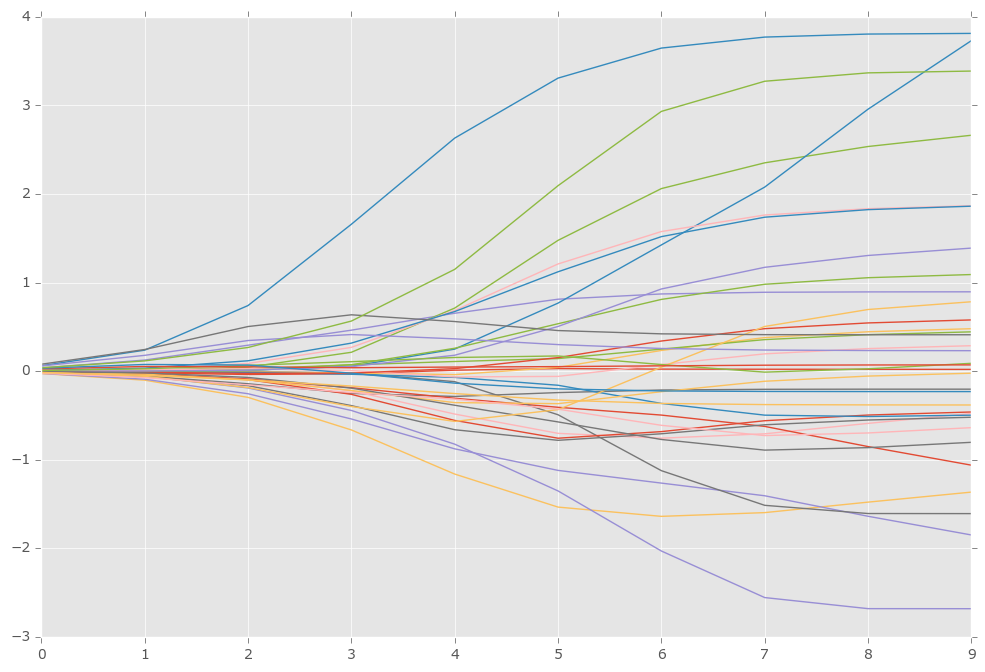

In [66]:
plt.plot(coefs[:, 1:].T)

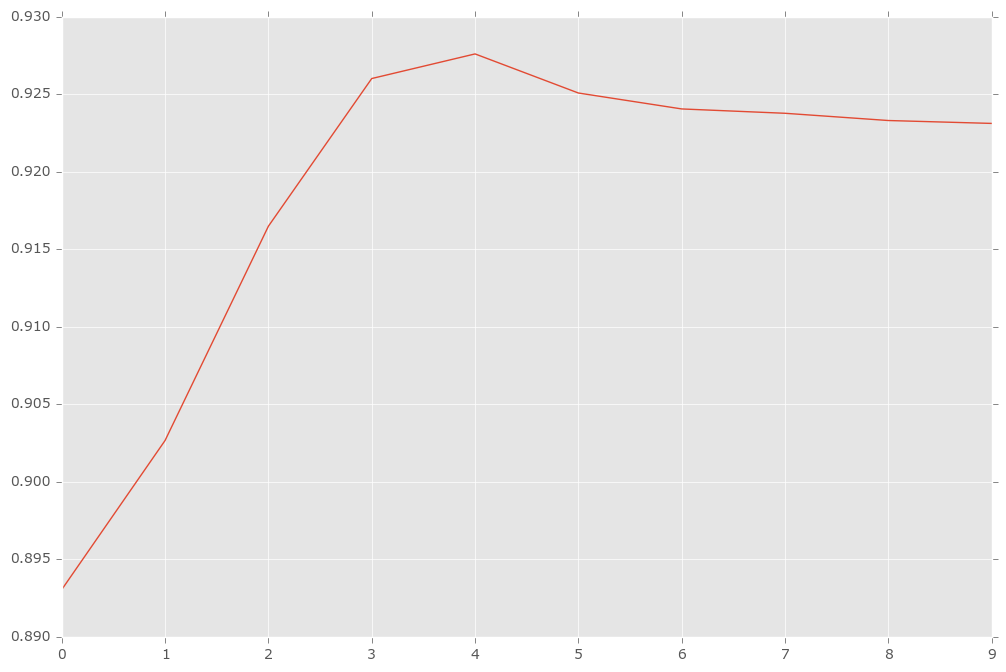

In [67]:
plt.plot(scores)

In [68]:
c_range[4]

0.46415888336127775

## Tree embedding

Вот так (примерно) выглядит скор-карта на выдачу кредита

<img src='https://www.mathworks.com/help/finance/credit_score_card_overview.png'>

Каждый "признак" разбит на бины (bins) - значимые интервалы. Если значение признака попадает в интервал, то к скору заемщика прибавляется сооветвтвующая величина.

Таким образом формируется итоговый скор и далее принимается решение о выдаче кредита.

Оценка порого бинов для признаков - это отдельная наука. Скоррингисты используют так называемое IV (information value) для оценки качества разбиения признака на бины.

На прошлом занятии мы изучили с вами другой способ выявления порогов на признаках - деревья решений (случайный лес). Почему бы нам это не использовать

### Задание
* Разбейте выборку на 2 части (обучение и контроль)
* На половине обучающей выборке обучите случайный лес
* С помощью метода `rand_forest.apply(X)` можно получить матрицу размера $n \times t$, где $t$ - количество деревьев в лесу. В эту матрицу будет числом записан номер листа, в который попал объект
* One-Hot Encoding!
* Обучите логистическую регрессию на второй половине обучающей выборки
* Сравние roc-auc на обычной лог-регрессии, обычного случайного леса и их композиции

In [114]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

In [119]:
X_train2, X_emb, y_train2, y_emb = train_test_split(X_train, y_train, 
                                                    test_size = 0.5, random_state=123)

In [120]:
rand_forest = RandomForestClassifier(n_estimators=100, max_depth=3)
rand_forest.fit(X_emb, y_emb)

X_train2_emb = rand_forest.apply(X_train2)
X_test_emb = rand_forest.apply(X_test)

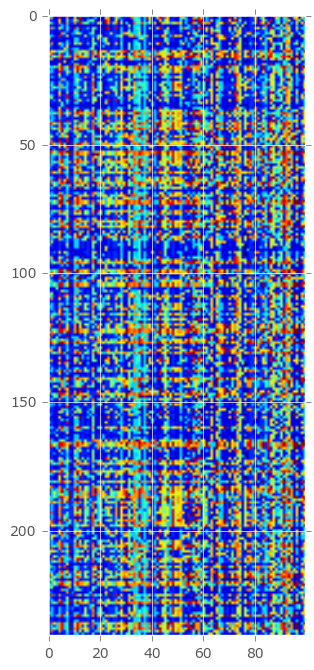

In [121]:
plt.imshow(X_train2_emb)

In [122]:
from sklearn.pipeline import Pipeline

In [123]:
# Комбо модель
model1 = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore')),
                  ('logreg', LogisticRegression())])
model1.fit(X_train2_emb, y_train2)

# Простой лес
model2 = RandomForestClassifier(n_estimators=100, max_depth=3)
model2.fit(X_train, y_train)

# Простая лог регрессия
model3 = LogisticRegression()
model3.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [124]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

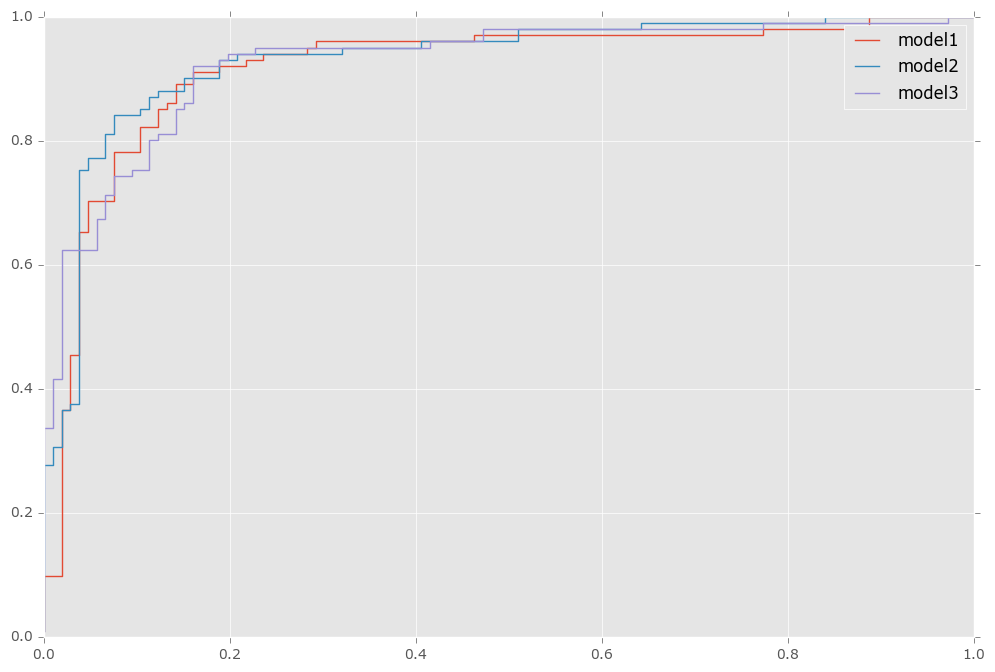

In [126]:
for i, model in enumerate([model1, model2, model3]):
    try:
        y_hat = model.predict_proba(X_test_emb)[:, 1]
    except:
        y_hat = model.predict_proba(X_test)[:, 1]
        
    fpr, tpr, thresholds = roc_curve(y_test, y_hat)
    
    plt.plot(fpr, tpr, label='model%d' % (i+1))
    
plt.legend()



# Линейная регрессия

Квадратичная ошибка достаточно чувствительна к выбросам. Давайте вернемся к нашим данным про автомобили и добавим туда выбросы.

Посмотрим, как поведет себя простая линейная регрессия.

In [128]:
df_train = pd.read_csv('http://bit.ly/1gIQs6C')

In [129]:
X_train = df_train.mileage.values.reshape(-1, 1)
y_train = df_train.price.values

n = y_train.shape[0]

In [130]:
## Добавляем выбросы

In [137]:
X_train = np.r_[X_train, [[250000+np.random.rand()*10000]]]
y_train = np.r_[y_train, 16000+np.random.randn()*1000]

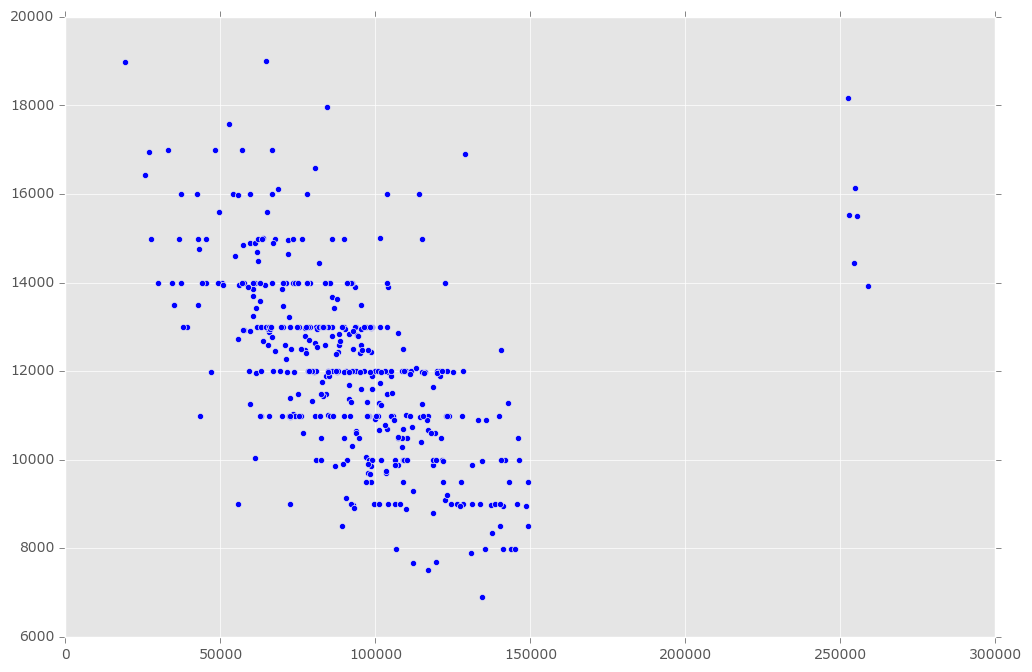

In [138]:
plt.scatter(X_train, y_train)

In [140]:
from sklearn.linear_model import LinearRegression

In [141]:
model = LinearRegression(fit_intercept=True)
model.fit(X_train[:n], y_train[:n])

model_ouliers = LinearRegression(fit_intercept=True)
model_ouliers.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

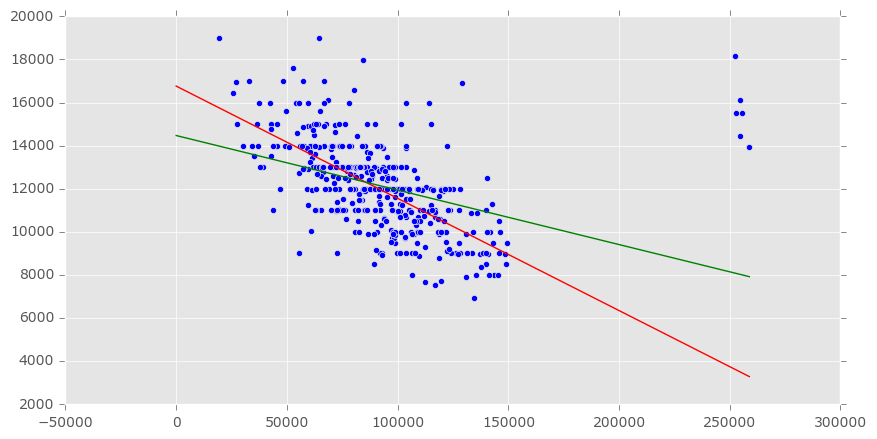

In [142]:
x = np.linspace(0, max(X_train), 100).reshape(-1, 1)
y_hat = model.predict(x)
y_hat_outliers = model_ouliers.predict(x)

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.scatter(X_train, y_train)

ax.plot(x, y_hat, c='red')
ax.plot(x, y_hat_outliers, c='green')

### RANSAC регрессия

Идея метода RANdom SAmple Consensus (RANSAC) заключается в многократном обучении модели на случайном наборе точек из исходных данных с последующим выбором лучшей модели.

То есть:
* Задаем функцию потерь
* Задаем порог $\theta$ для остатков при котором наблюдения начинают относится к выбросам
* Задаем правило останова

Шаги алгоритма следующие
1. Взять случайные K точек и обучить на них модель M
2. Сравнить ошибки на остальных точких с порогом $\theta$ и отнести к выбросам или внутренним точкам
3. Обучить модель на всех внутренних точках, оценить качество на внутренних точках
4. Повторить 1-3 пока не наступит правило останова. 
5. Вывод: модель с лучшим качеством

In [143]:
from sklearn.linear_model import RANSACRegressor

In [144]:
model_ransac = RANSACRegressor(LinearRegression())
model_ransac.fit(X_train, y_train)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_trials=100, min_samples=None, random_state=None,
        residual_metric=None, residual_threshold=None, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

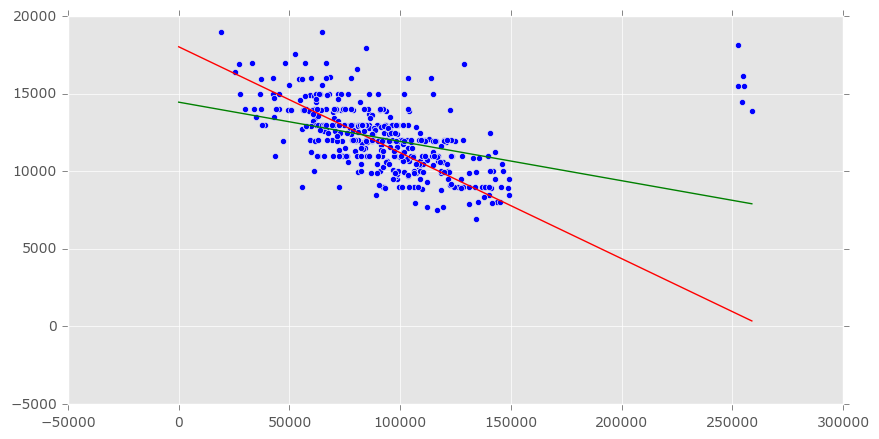

In [146]:
x = np.linspace(0, max(X_train), 100).reshape(-1, 1)
y_hat = model_ransac.predict(x)

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.scatter(X_train, y_train)

ax.plot(x, y_hat, c='red')
ax.plot(x, y_hat_outliers, c='green')

### Robust Estimators

Идея робастных методов заключается во взвешивании остатков модели таким образом, чтобы большие значения вносили меньший вклад в оценку параметров.

Таким образом, вместо минимизации квадрата остатков $$ L(\beta_0,\beta_1,\dots) = \frac{1}{2n}\sum^{n}_{i=1}(\hat{y}^{(i)} - y^{(i)})^2$$
Будут минимизироваться взвешенные остатки $$ L_w(\beta_0,\beta_1,\dots) = \frac{1}{2n}\sum^{n}_{i=1}\rho(\hat{y}^{(i)} - y^{(i)}),$$
где $\rho(\cdot)$ - некоторая взвешивающая функция.

Для того, чтобы попробовать эти методы нужно будет устновить пакет `statsmodels` через `pip`

In [147]:
!pip install statsmodels

In [148]:
import statsmodels.api as sm

(0.1, -4.1)

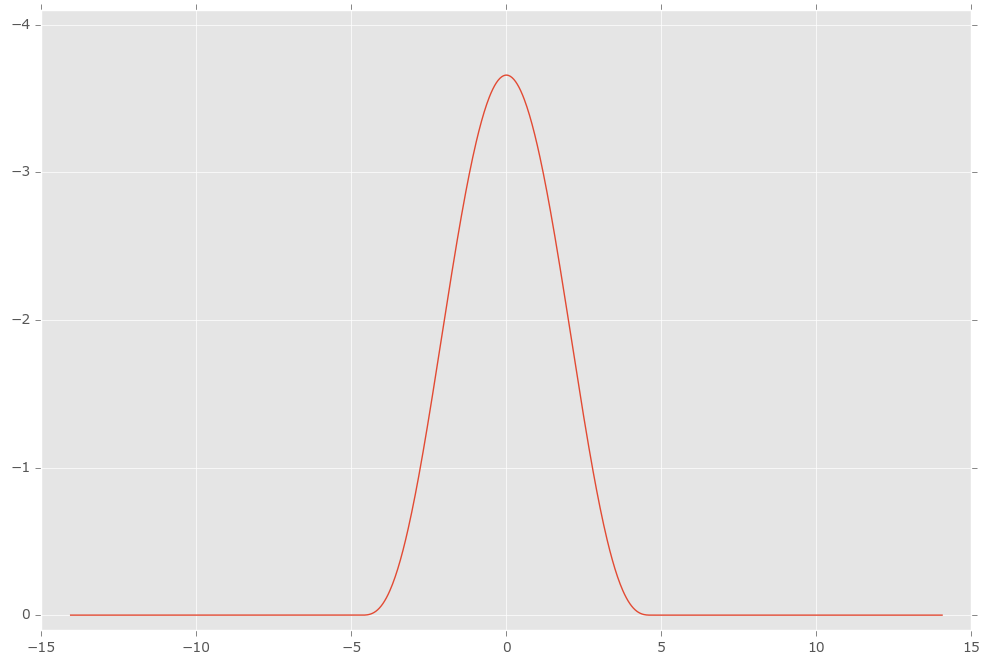

In [149]:
c = 4.685
support = np.linspace(-3*c, 3*c, 1000)
tukey = sm.robust.norms.TukeyBiweight(c=c)
plt.plot(support, tukey(support))
plt.ylim(.1, -4.1)

In [150]:
model_robust = sm.RLM(y_train, sm.add_constant(X_train), M=sm.robust.norms.TukeyBiweight())
model_robust = model_robust.fit()

In [151]:
model_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                      y   No. Observations:                  423
Model:                            RLM   Df Residuals:                      421
Method:                          IRLS   Df Model:                            1
Norm:                   TukeyBiweight                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 16 Feb 2017                                         
Time:                        21:58:15                                         
No. Iterations:                     8                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.682e+04    217.077     77.479      0.000    1.64e+04    1.72e+04
x1            -0.0534      0.002    -24.007      0.000      -0.058      -0.049
==============================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

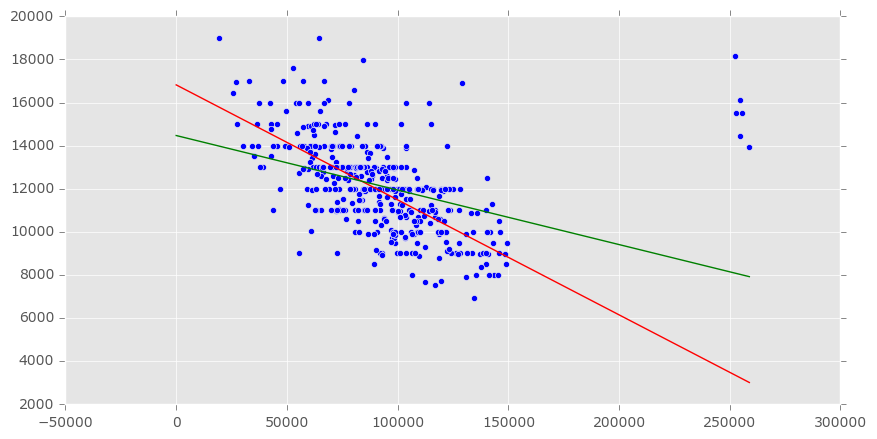

In [152]:
x = np.linspace(0, max(X_train), 100).reshape(-1, 1)
y_hat = model_robust.predict(sm.add_constant(x))

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.scatter(X_train, y_train)

ax.plot(x, y_hat, c='red')
ax.plot(x, y_hat_outliers, c='green')

## Немного практики

Загрузите [данные](http://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv) о лесных пожарах в некоторых областях парка Montesinho в Португалии.

Описание данных следующее:
1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: 'jan' to 'dec'
4. day - day of the week: 'mon' to 'sun'
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3
7. DC - DC index from the FWI system: 7.9 to 860.6
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 

Описание индексов FFMC, DMC, CD, ISI приводится [здесь](http://cwfis.cfs.nrcan.gc.ca/background/summary/fwi)

Ваша задача - по данным признакам 1-12 предсказать признак 13, площадь области, которая подвергнется пожару.

Перед тем как приступать с модели, постройте гистрограмму площади пожара `area`. Что можно сказать о том, как распределены значения? Рассмотрите различные преобразования, например `log(area+1)` или `sqrt(area)` и выберите то, которое будет лучше использовать для предсказания (линейной моделью).

In [ ]:
##  Your Code Here

### Преобразование признаков

Выполните преобразование признаков, а именно:

* Нормализацию вещественных признаков с помощью z-score (x - x.mean())/x.std(). Нормализацию зависимой переменной `area` выполнять не надо.
* Преобразование номинальных признаков `month` и `day` в числовое представление.
* Имеет ли смысл преобразование для признаков `X` и `Y`? Если да - выполните его.


На выходе вы должны получить матрицы X_train и X_test с преобразованными признаками, а так же векторы ответов y_train и y_test.ь

In [ ]:
##  Your Code Here

### Обучение

Обучите две модели:

* Простую линейную регрессию `LinearRegression` (без регуляризации). Выберите такое подмножество признаков из X_train, чтобы избежать мультиколлинеарности.
* Любую другую понравившеюся вам модель.

Расчитайте предсказания для контролькой выборки. 

* Найдите среднюю абсолютную ошибку модели на контрольной выборке
* Постройте график зависимости ошибок $|(\text{area}) - (\text{predicted_area})|$ и значений признака $\text{area}$, где $\text{area}$ и $\text{predicted_area}$ - значения в исходной шкале, а не преобзованной после задания 2.1
* Какие значения модель предсказывает лучше?

In [ ]:
##  Your Code Here